In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw6.ipynb")

## Homework #6

*Please edit the cell below to add your name, NetID, and any group members that you collaborated with on this assignment.* **Complete this section before proceeding to the assignment questions.**

Name: Runze Li  
NetID: rl50xx  
Group Members: None   
***

In [2]:
# Set random seed and ensure plots are displayed in the notebook
import numpy as np
import pymc as pm
import arviz as az
rnd_seed = 42
np.random.seed(rnd_seed)
%matplotlib inline

%config Inline.figure_format = 'retina'
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

### <!-- BEGIN QUESTION -->

**Question 1**. **(15 points)** In 2014, a paper was published that was entitled “Female hurricanes are deadlier than male hurricanes.” As the title suggests, the paper claimed that hurricanes with female names have caused greater loss of life, and the explanation given is that people unconsciously rate female hurricanes as less dangerous and so are less likely to evacuate. Statisticians severely criticized the paper after publication.

Here, you’ll explore the complete data used in the paper and consider the hypothesis that hurricanes with female names are deadlier.

Load the data as follows:

`df = pd.read_csv("Data/hurricanes.csv")`


The columns have the following meaning:
```
*Description*
Data used in Jung et al 2014 analysis of effect of gender of name on hurricane fatalities. Note that hurricanes Katrina (2005) and Audrey (1957) were removed from the data.

name : Given name of hurricane

year : Year of hurricane

deaths : Number of deaths

category : Severity code for storm

min_pressure : Minimum pressure, a measure of storm strength; low is stronger

damage_norm : Normalized estimate of damage in dollars

female : Indicator variable for name categorized as "female"

femininity : 1-11 scale from totally masculine (1) to totally feminine (11) for name. Average of 9 scores from 9 raters.

*Reference* 
Jung et al. 2014. Female hurricanes are deadlier than male hurricanes. PNAS.
```

To begin, you will focus on constructing Poisson Generalized Linear Models to investigate the relationship between name femininity and hurricane deaths. In pursuing this goal, you will fit two different statistical models. One will be an intercept-only model of the expected number of deaths from a hurricane using an intercept term with no predictors in the model. The second will include an intercept and a storm's femininity score as a predictor to model the expected number of deaths.

**Begin by justifying the priors used in your models for this problem using a prior predictive simulation.** 

1. Perform a brief web search on the expected number deaths due to hurricanes to help choose reasonable priors for your model. 
1. Include a brief statement on the information obtained and the source(s) used based on your web search.
1. **Perform two seperate prior predictive simulations**: one for the intercept-only model and one for the model that includes femininity score as a predictor.
    * For an intercept-only model, a good way to analyze the prior for the intercept parameter is to view the distribution of prior samples using a histogram or kde plot.
    * For the model that includes femininity as a predictor, you prior predictive simulation will include a plot of femininity vs expected number of deaths that shows how the expected number of deaths change as the (standadized) femininity score changes.
    * Refer to the Poisson GLM lecture (slides titled "Poisson Priors") for examples of prior predictive simulations for both types of models.

In [4]:
# Write code here
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

In [5]:
df = pd.read_csv("Data/hurricanes.csv", header=0)

df["Femi"] = standardize(df.femininity).values
df["Fe"] = df.female
df["D"] = df.deaths

df

,name,year,deaths,category,min_pressure,damage_norm,female,femininity,Femi,Fe,D
0,Easy,1950,2,3,960,1590,1,6.77778,-0.000935,1,2
1,King,1950,4,3,955,5350,0,1.38889,-1.670758,0,4
2,Able,1952,3,1,985,150,0,3.83333,-0.913314,0,3
3,Barbara,1953,1,1,987,58,1,9.83333,0.945870,1,1
4,Florence,1953,0,1,985,15,1,8.33333,0.481074,1,0
...,...,...,...,...,...,...,...,...,...,...,...
87,Gustav,2008,52,2,954,4360,0,1.72222,-1.567471,0,52
88,Ike,2008,84,2,950,20370,0,1.88889,-1.515826,0,84
89,Irene,2011,41,1,952,7110,1,9.27778,0.773725,1,41
90,Isaac,2012,5,1,966,24000,0,1.94444,-1.498613,0,5


/opt/conda/envs/fnds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


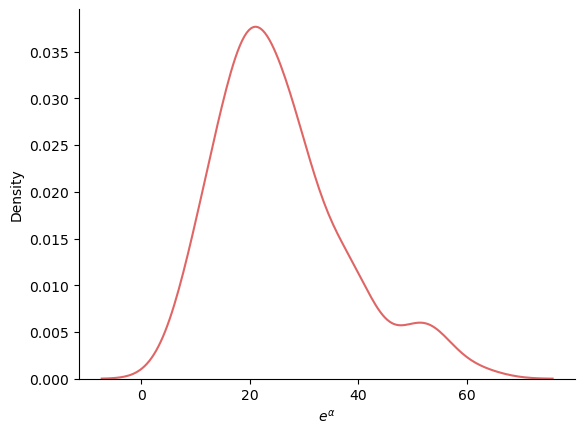

In [6]:
alphas2 = stats.norm.rvs(3.2, 0.5, size = 100)
lambdas2 = np.exp(alphas2)

sns.kdeplot(lambdas2, color="#e06666")
plt.xlabel(r"$e^{\alpha}$")
sns.despine();

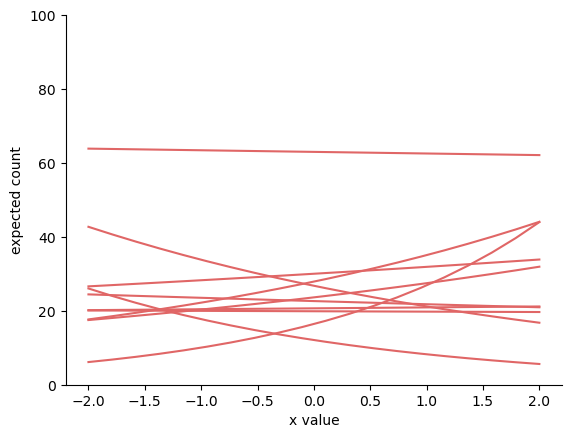

In [7]:
NUM_LINES = 10
x_seq = np.linspace(-2, 2, 20)

alpha = stats.norm.rvs(3.2, 0.5,size=NUM_LINES)
beta = stats.norm.rvs(0, 0.2,size=NUM_LINES)

for i in range(NUM_LINES):
    lambdas = np.exp(alpha[i] + beta[i] * x_seq)
    _ = plt.plot(x_seq, lambdas, color="#e06666")
    
plt.ylim((0,100))
plt.ylabel("expected count")
plt.xlabel("x value")
sns.despine();

__Answer:__    

We know from the material that the expected number of deaths caused by the hurricane is 24, so we take $alpha=ln(24)=3.2$ here.

Reference: https://news.stanford.edu/stories/2024/10/study-links-hurricanes-to-higher-death-rates-long-after-storms-pass

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Approximate the posterior of a Poisson model of hurricane deaths using femininity (**after standardization**) as a predictor. This **model will include two parameters**: an **intercept** and a **coefficient** that measures the effect of femininity on the expected number of deaths.

In [8]:
# Write code here

# interaction model
with pm.Model() as m11_10:
    a = pm.Normal("a", 3.2, 0.5)
    b = pm.Normal("b", 0.0, 0.2)

    Femi = pm.MutableData("Femi", df.Femi)
    lam = pm.math.exp(a + b * Femi)

    D = pm.Poisson("deaths", lam, observed=df.D)
    idata_11_10 = pm.sample(
                    tune=3000, 
                    random_seed=145,
                    idata_kwargs={"log_likelihood": True}
    )

az.summary(idata_11_10, kind="all")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a, b]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.002,0.023,2.965,3.038,0.001,0.0,1469.0,1224.0,1.0
b,0.234,0.025,0.191,0.271,0.001,0.0,1555.0,1344.0,1.0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Approximate the posterior of a Poisson model of hurricane deaths defining the expected number of deaths using just an intercept term. This model will include only one parameter to estimate.

In [9]:
# Write code here

# intercept only
with pm.Model() as m11_9:
    a = pm.Normal("a", 3.2, 0.5)
    D = pm.Poisson("deaths", pm.math.exp(a), observed=df.D)
    idata_11_9 = pm.sample(
                    tune=3000, 
                    random_seed=145,
                    idata_kwargs={"log_likelihood": True}
    )

az.summary(idata_11_9, kind="all")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [a]


Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.027,0.022,2.991,3.062,0.001,0.001,805.0,1370.0,1.0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Based on the model estimates, how strong is the association between femininity of storm name and deaths? 

The response to this question should be based on parameter estimate(s) from your model. **Be sure to reference the estimated association (using a quantitative anaysis or visual analysis of a plot) in your answer.**

__Answer:__   

Femininity of storm names are positively correlated with deaths, but the correlation is not so strong, as shown by the value of beta.

In [10]:
# Write code here
az.summary(idata_11_10, kind="all")

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.002,0.023,2.965,3.038,0.001,0.0,1469.0,1224.0,1.0
b,0.234,0.025,0.191,0.271,0.001,0.0,1555.0,1344.0,1.0


In [11]:
az.summary(idata_11_9, kind="all")

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.027,0.022,2.991,3.062,0.001,0.001,805.0,1370.0,1.0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2**. **(15 points)** In this problem, you’ll focus on predicting deaths using the femininity score of each hurricane’s name. 

Perform posterior predictive checks to evaluate how well the femininity score model predicts the observed data. This posterior predictive check will include a plot with the following components: 

* name femininity (standardized) on the x-axis
* number of deaths on the y-axis
* observed death counts from the dataset as scatter plot points
* posterior mean showing the average relationship between femininity and number of deaths
* uncertainty of posterior mean
* uncertainty of posterior predictions (requires making predictions using samples from your posterior) 

An example of this approach to performing posterior predictive checks can be found in the *Linear Regression* lecture in the section titled "Posterior Predictive Checks". You will want to generalize the approach from that lecture so that it applies to a Poisson regression model. Feel free to use the function `pymc.sample_posterior_predictive()` to reduce the amount of code that you write. 

In [12]:
# Write code here
ns = 92
F_seq = np.linspace(-2.0, 1.5, ns)

with m11_10:
    pm.set_data({"Femi": F_seq})
    lam = az.extract(
        pm.sample_posterior_predictive(idata_11_10, var_names=["deaths"]),
        group="posterior_predictive"
    )["deaths"]

lmu = lam.mean("sample")

Sampling: [deaths]


In [13]:
# store pareto-k values for plot:
k = az.loo(idata_11_10, pointwise=True).pareto_k.values
k

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


array([ 1.73603618e-01,  2.69942903e-01,  1.94140662e-01,  2.13511857e-01,
        9.45183592e-02,  2.16096256e-01, -1.19320963e-02,  3.43881995e-02,
        1.02796621e-01,  2.06225475e+00,  3.95712121e-02,  2.48405396e-02,
        2.28863376e-01,  2.40057259e-01,  1.46931660e-02,  2.40147296e-01,
        1.31719165e-01,  1.71188235e-01,  2.20905863e-01,  9.62114334e-02,
        1.44360359e-01,  8.42173552e-03,  1.78373858e-01,  3.42414640e-01,
        8.96735136e-02,  7.28901940e-02, -1.39952793e-02,  1.17858285e-01,
        2.41316797e+00,  3.71256418e-02,  1.02796621e-01,  8.07812804e-02,
        2.64057104e-01,  8.16709313e-01,  1.23054938e-01, -1.77971633e-04,
        2.32010327e-01,  1.78661978e-01,  3.06122205e-01,  1.12846942e-01,
        2.39589920e-01,  2.42442125e-01,  2.87867676e-02,  2.20905863e-01,
        3.23626739e-01,  3.16822017e-01,  1.59221902e-01,  1.33032203e-01,
        1.45221585e-01,  1.46846522e-01,  1.75828166e-01,  1.95140851e-01,
        3.22762096e-01,  

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'deaths')

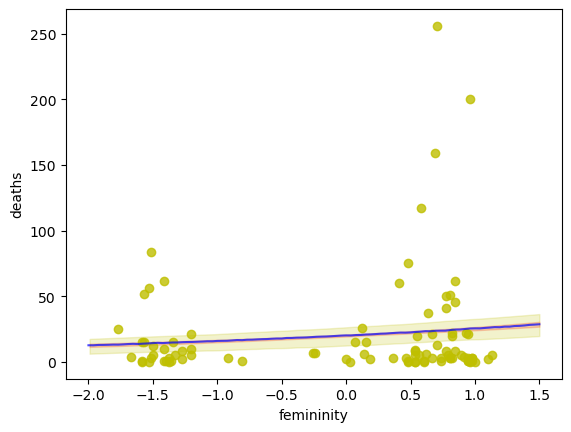

In [14]:
k /= k.max()
psize = 250 * k

F_seq = np.linspace(-2.0, 1.5, ns)

idata_thinned = az.extract(idata_11_10, num_samples=1000)
lam_pred = np.zeros((len(F_seq), idata_thinned.sizes["sample"]))
d_pred = np.zeros((len(F_seq), idata_thinned.sizes["sample"]))
a_values = idata_thinned.a.values
b_values = idata_thinned.b.values

for i, f in enumerate(F_seq):
    lam_pred[i] = np.exp(a_values+b_values*f)
    d_pred[i] = stats.poisson.rvs(lam_pred[i])

plt.plot(F_seq, lmu, color="b", alpha=0.7, label="posterior mean")
az.plot_hdi(F_seq, lam_pred.T, color="red", fill_kwargs={"alpha": 0.2})
az.plot_hdi(F_seq, d_pred.T, color="y", fill_kwargs={"alpha": 0.2})
plt.scatter(df.Femi.values, df.deaths.values, facecolors='y',alpha=0.8)
plt.xlabel("femininity")
plt.ylabel("deaths")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Based on your plot, how effective is the femininity score model at predicting storm deaths?

__Answer:__

For cases with relatively small deaths, the femininity score model is relatively effective in predicting, but for hurricanes with relatively large deaths, the model's predictive ability is not effective.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Compare the predictive ability** of the hurricane name femininity model to the intercept-only model. **State which model is better for prediction** based on the predictive criteria tools (PSIS or WAIC) covered earlier in the semester.

In [15]:
# Write code here
model_dict = {
    "m11_9": idata_11_9,
    "m11_10": idata_11_10
}

In [16]:
compare_df_psis = az.compare(
    compare_dict=model_dict,
    ic="loo",
    scale="deviance"
)
compare_df_psis

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m11_10,0,4379.613138,114.626669,0.000000,0.468407,979.845214,0.000000,True,deviance
m11_9,1,4422.359901,66.087285,42.746763,0.531593,1060.061231,141.379546,True,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


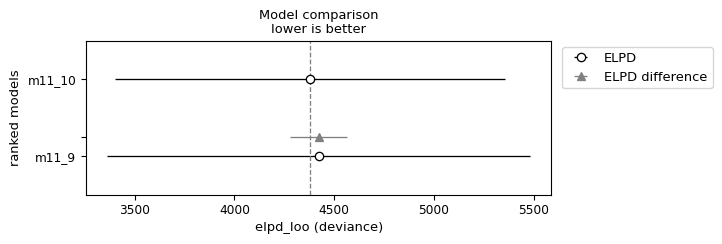

In [17]:
_ = az.plot_compare(compare_df_psis)

In [18]:
compare_df_waic = az.compare(
    compare_dict=model_dict,
    ic="waic",
    scale="deviance"
)
compare_df_waic

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureW

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
m11_10,0,4411.838143,130.739172,0.000000,0.468415,999.837014,0.00000,True,deviance
m11_9,1,4443.688874,76.751771,31.850731,0.531585,1073.690078,137.53045,True,deviance


/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


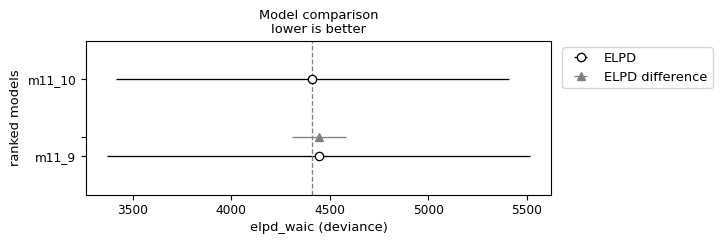

In [19]:
_ = az.plot_compare(compare_df_waic)

__Answer:__

From the graph we can see that the model with two parameters (an intercept and a coefficient) is better.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Which storms does the model including femininity as a predictor fit poorly? 

Hints for this question:  

* Reviewing the prediction tutorial and the *Prediction* lecture from earlier in the semester will be beneficial for answering this question and the next. 
* You will want to quantify the influence that each data point has on the model's posterior. Data points that are fit poorly by the model will have more influence on the posterior distribution.
* You'll want to examine the relationship between storm femininity scores and the influence of the data points which the model does not fit well. 

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


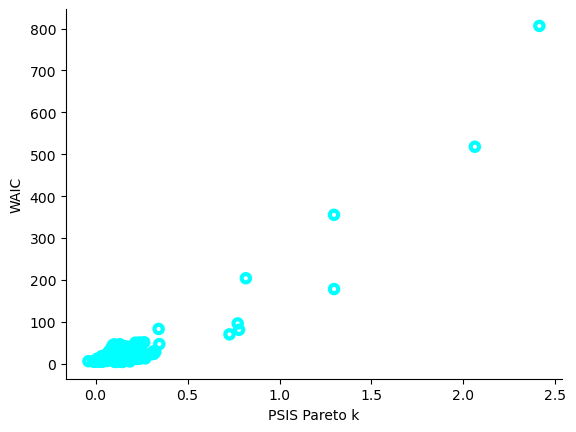

In [20]:
# Write code here
psis = az.loo(idata_11_10, pointwise=True, scale="deviance")
waic = az.waic(idata_11_10, pointwise=True, scale="deviance")

plt.scatter(psis.pareto_k, waic.waic_i, facecolors='none', edgecolors="cyan", lw=3)
plt.xlabel("PSIS Pareto k")
plt.ylabel("WAIC")
sns.despine();

In [21]:
df2 = pd.DataFrame({
    "name": df.name,
    "psis": psis.pareto_k,
    "waic": waic.waic_i,
    "female": df.female,
    "femininity": df.femininity
})

In [22]:
# Sort the DataFrame by the 'psis' column in descending order
df2 = df2.sort_values(by="psis", ascending=False)
df2 = df2.head(8)
df2

,name,psis,waic,female,femininity
28,Camille,2.413168,806.196217,1,9.05556
9,Diane,2.062255,517.968756,1,9.88889
88,Ike,1.296607,178.446880,0,1.88889
91,Sandy,1.296351,355.538139,1,9.00000
33,Agnes,0.816709,204.260259,1,8.66667
69,Floyd,0.779776,81.215514,0,1.83333
58,Andrew,0.772422,96.446407,0,2.22222
87,Gustav,0.727773,70.333346,0,1.72222


__Answer:__

From the chart, we can see that the model fit effect of 8 hurricanes is poor. Therefore, we sort them in descending order of psis and get the names of 8 hurricanes:

- 28 Camille
- 9 Diane
- 88 Ike
- 91 Sandy
- 33 Agnes
- 69 Floyd
- 58 Andrew
- 87 Gustav

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

In light of the analysis performed in this question and the previous one, what do you make of the claim that female hurricanes are deadlier than male hurricanes because people unconsciously rate female hurricanes as less dangerous and so are less likely to evacuate? 

* Consider both the causal and predictive analyses performed on the dataset. 
* Be sure to support your response based on the analysis you have performed.

**Limit your response to no more than 4 sentences.**

__Answer:__   

I don't think that female hurricanes are deadlier than male hurricanes. According to the chart, hurricanes with less feminine names (such as Ike, Floyd, Andrew, and Gustav) also caused a larger number of deaths.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3**. **(20 points)** In the trolley data — `Data/Trolley.csv` — we saw how education level (modeled as an ordered category) is associated with responses. But is this association causal? One plausible confound is that education is also associated with age through a causal process: People are older when they finish school than when they begin it.

Reconsider the trolley data in this light. 

Include a DAG (reference the DAG tutorial included with Homework 5 for instructions creating a DAG in Python) that represents causal relationships amongst response, education, and age **based on the associations described above**. For the purposes of this problem, you can ignore any other variables from the dataset in this DAG. **Clearly identify what each variable in your DAG represents**.

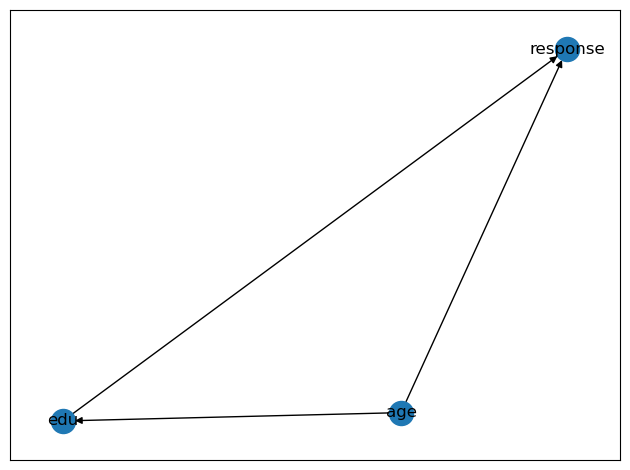

In [23]:
# Write code here
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
graph.add_edges_from([("edu", "response"), ("age", "response"), ("age", "edu")])
nx.draw_networkx(graph, arrows=True)
plt.tight_layout()

__Answer:__

The DAG diagram is shown above. In the subsequent model, we will record response as R, age as Y, and edu as E.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**State** which statistical model (or models) and their adjustment set(s) you need to evaluate the causal influence of education on responses and **explain your choice**. 

__Answer:__

For the casual influence of education on responses, we adjust for 'age' in the adjustment sets. The statistical model is as below:   

<!-- $$
\begin{align}
R_i \sim OrderedLogit(\phi_i, \alpha) \\
\phi_i = \beta_E \sum_{j=0}^{E_i-1} \delta_j + \beta_A A_i + \beta_C C_i + \beta_I I_i + \beta_Y Y_i \\
\alpha_k \sim Normal(0, 1) \\
\beta_- \sim Normal(0, 0.5) \\ 
\delta \sim Dirichlet(a) \\
a = [2, 2, 2, 2, 2, 2, 2]
\end{align}
$$ -->

- $R_i \sim OrderedLogit(\phi_i, \alpha)$
- $\phi_i = \beta_E \sum_{j=0}^{E_i-1} \delta_j + \beta_A A_i + \beta_C C_i + \beta_I I_i + \beta_Y Y_i$
- $\alpha_k \sim Normal(0, 1)$
- $\beta_- \sim Normal(0, 0.5)$
- $\delta \sim Dirichlet(a)$
- $a = [2, 2, 2, 2, 2, 2, 2]$

This model is suitable for total and direct causal influence of education on responses, and direct causal influence of age on responses.

What's more, we build another model which is suitable for total causal influence of age on responses:

<!-- $$
\begin{align}
R_i \sim OrderedLogit(\phi_i, \alpha) \\
\phi_i = \beta_A A_i + \beta_C C_i + \beta_I I_i + \beta_Y Y_i \\
\alpha_k \sim Normal(0, 1) \\
\beta_- \sim Normal(0, 0.5)
\end{align}
$$ -->

- $R_i \sim OrderedLogit(\phi_i, \alpha)$
- $\phi_i = \beta_A A_i + \beta_C C_i + \beta_I I_i + \beta_Y Y_i$
- $\alpha_k \sim Normal(0, 1)$
- $\beta_- \sim Normal(0, 0.5)$

**Approximate the posterior distribution(s) for the parameters of the model(s)** using the trolley data. **Include the treatment combinations (Action, Intention, Contact) in your model(s) as a competing cause** as demonstrated in lecture.  

Note: *Sampling the posterior for this model and dataset using Hamiltonian Monte Carlo MCMC uses more memory than other models we have seen in this course. This is one of the drawbacks of this technique: its inability to scale efficiently to the size of the input data. Therefore, you should only **use a random subset of the data** when sampling from the posterior. The code below samples only about 70% of the observed data. Feel free to use the code exactly as written below:*  

```
import pandas as pd
trolley_df = pd.read_csv("Data/Trolley.csv", sep=";").sample(n=7000)
```

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->



In [24]:
# Write code here
import pytensor.tensor as pt
import warnings

In [25]:
trolley_df = pd.read_csv("Data/Trolley.csv", sep=";").sample(n=7000)
trolley_df["edu_new"] = pd.Categorical(
    trolley_df.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
trolley_df["edu_new"] = trolley_df.edu_new.cat.codes
trolley_df

,case,response,order,id,age,male,edu,action,intention,contact,story,action2,edu_new
3591,ikshi,2,17,97;123,58,0,Bachelor's Degree,1,1,0,shi,1,5
5341,cfbur,5,31,97;439,32,1,Master's Degree,0,0,1,bur,1,6
9908,fkbox,3,11,98;299,66,1,Graduate Degree,1,0,0,box,1,7
590,ikpon,3,1,96;533,23,0,Bachelor's Degree,1,1,0,pon,1,5
9748,ilswi,1,18,98;222,63,1,High School Graduate,0,1,0,swi,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,ilbox,6,23,96;570,57,1,Graduate Degree,0,1,0,box,0,7
7577,flswi,5,27,97;757,55,1,Master's Degree,0,0,0,swi,0,6
5989,ikbur,1,20,97;591,42,1,Master's Degree,1,1,0,bur,1,6
7141,cfbur,4,32,97;724,24,1,Bachelor's Degree,0,0,1,bur,1,5


In [26]:
RANDOM_SEED = 8927
np.random.seed(365)

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set_context("talk")

In [27]:
R = trolley_df.response.values - 1
A = trolley_df.action.values
I = trolley_df.intention.values
C = trolley_df.contact.values
E = trolley_df.edu_new.values
Y = standardize(trolley_df.age.values)

In [28]:
with pm.Model() as mRXEY:
    alpha = pm.Normal(
        "alpha",
        0.0,
        1,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)
    bY = pm.Normal("bY", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = pt.concatenate([pt.zeros(1), delta])
    delta_j_cumulative = pt.extra_ops.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I + bY * Y

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints = alpha, observed=R)

    idata_RXEY = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, bA, bC, bI, bE, bY, delta]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 1069 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [29]:
az.summary(idata_RXEY, var_names=["bC", "bI", "bA", "bE", "bY", "alpha", "delta"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bC,-0.93,0.06,-1.02,-0.83,0.00,0.0,3064.08,2791.93,1.0
bI,-0.72,0.04,-0.79,-0.65,0.00,0.0,3811.02,2526.14,1.0
bA,-0.69,0.05,-0.76,-0.61,0.00,0.0,2927.87,2647.71,1.0
bE,0.20,0.14,-0.02,0.41,0.01,0.0,825.95,771.62,1.0
bY,-0.09,0.02,-0.13,-0.05,0.00,0.0,1821.90,2068.65,1.0
alpha[0],-2.67,0.11,-2.85,-2.49,0.00,0.0,808.80,770.87,1.0
alpha[1],-2.01,0.11,-2.17,-1.83,0.00,0.0,777.05,703.31,1.0
alpha[2],-1.42,0.11,-1.58,-1.24,0.00,0.0,767.63,689.05,1.0
alpha[3],-0.40,0.11,-0.57,-0.23,0.00,0.0,773.49,735.59,1.0
alpha[4],0.27,0.11,0.11,0.45,0.00,0.0,784.64,697.51,1.0


In [30]:
with pm.Model() as mRXY:
    alpha = pm.Normal(
        "alpha",
        0.0,
        1,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bY = pm.Normal("bY_total", 0.0, 0.5)

    phi = bA * A + bC * C + bI * I + bY * Y

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints = alpha, observed=R)

    idata_RXY = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, bA, bC, bI, bY_total]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 389 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [31]:
az.summary(idata_RXY, var_names=["bC", "bI", "bA", "bY_total", "alpha"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bC,-0.93,0.06,-1.02,-0.83,0.0,0.0,1737.00,2375.38,1.00
bI,-0.72,0.04,-0.78,-0.65,0.0,0.0,1711.62,2519.90,1.00
bA,-0.68,0.05,-0.76,-0.60,0.0,0.0,1333.84,1760.99,1.01
bY_total,-0.07,0.02,-0.11,-0.04,0.0,0.0,3636.09,3008.11,1.00
alpha[0],-2.80,0.06,-2.89,-2.72,0.0,0.0,993.90,1406.23,1.01
alpha[1],-2.14,0.05,-2.22,-2.06,0.0,0.0,916.72,1391.88,1.01
alpha[2],-1.55,0.05,-1.62,-1.47,0.0,0.0,910.79,1332.10,1.01
alpha[3],-0.53,0.04,-0.60,-0.46,0.0,0.0,867.21,1396.47,1.01
alpha[4],0.14,0.04,0.07,0.21,0.0,0.0,885.03,1475.03,1.01
alpha[5],1.04,0.05,0.96,1.11,0.0,0.0,1029.91,1714.15,1.01


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Now, answer the following questions:

* What do you conclude about the causal relationship between education and response? 
* What do you conclude about the causal relationship between age and response? 

Be sure to support your conclusions **with distribution plots** of your model's parameter estimates. **There is no need to perform a posterior predictive simulation.**
    
**Limit your response to no more than 8 sentences.**

In [32]:
# Write code here

array([<Axes: title={'center': 'bE'}>, <Axes: title={'center': 'bY'}>],
      dtype=object)

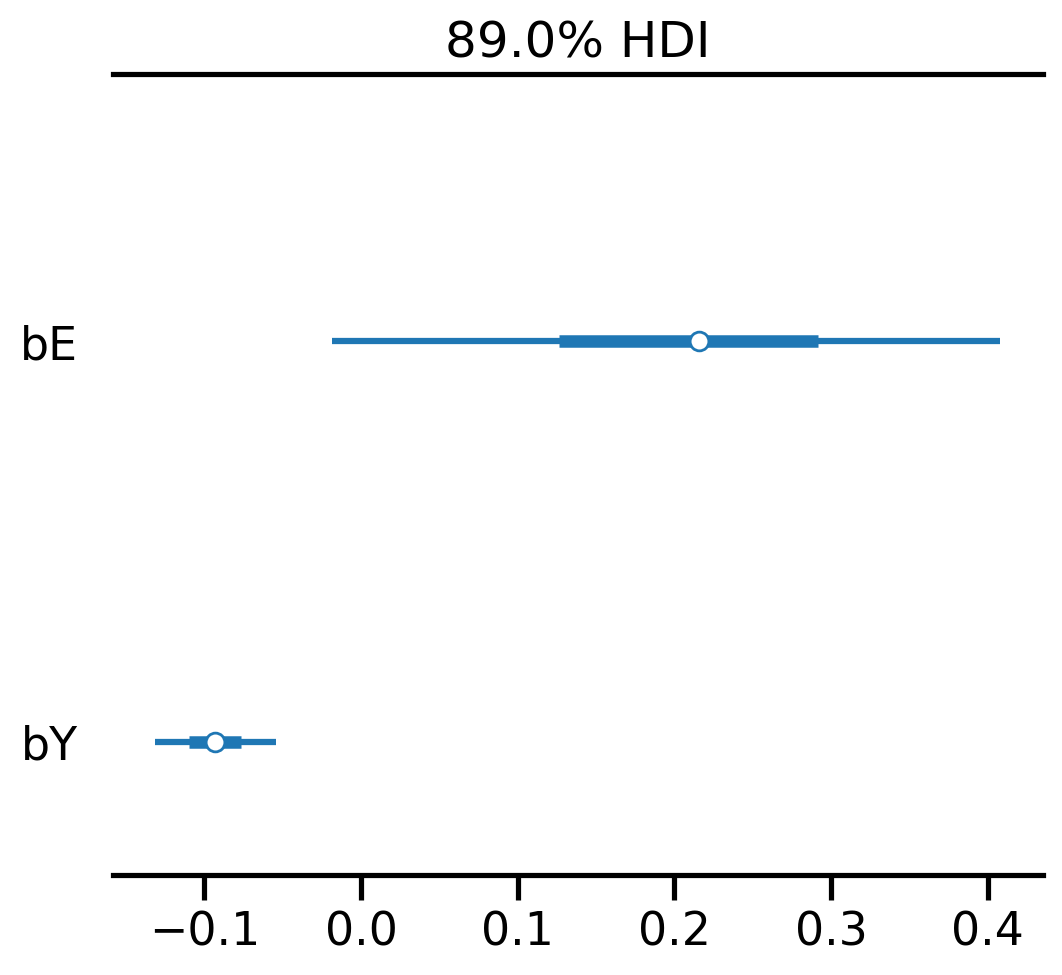

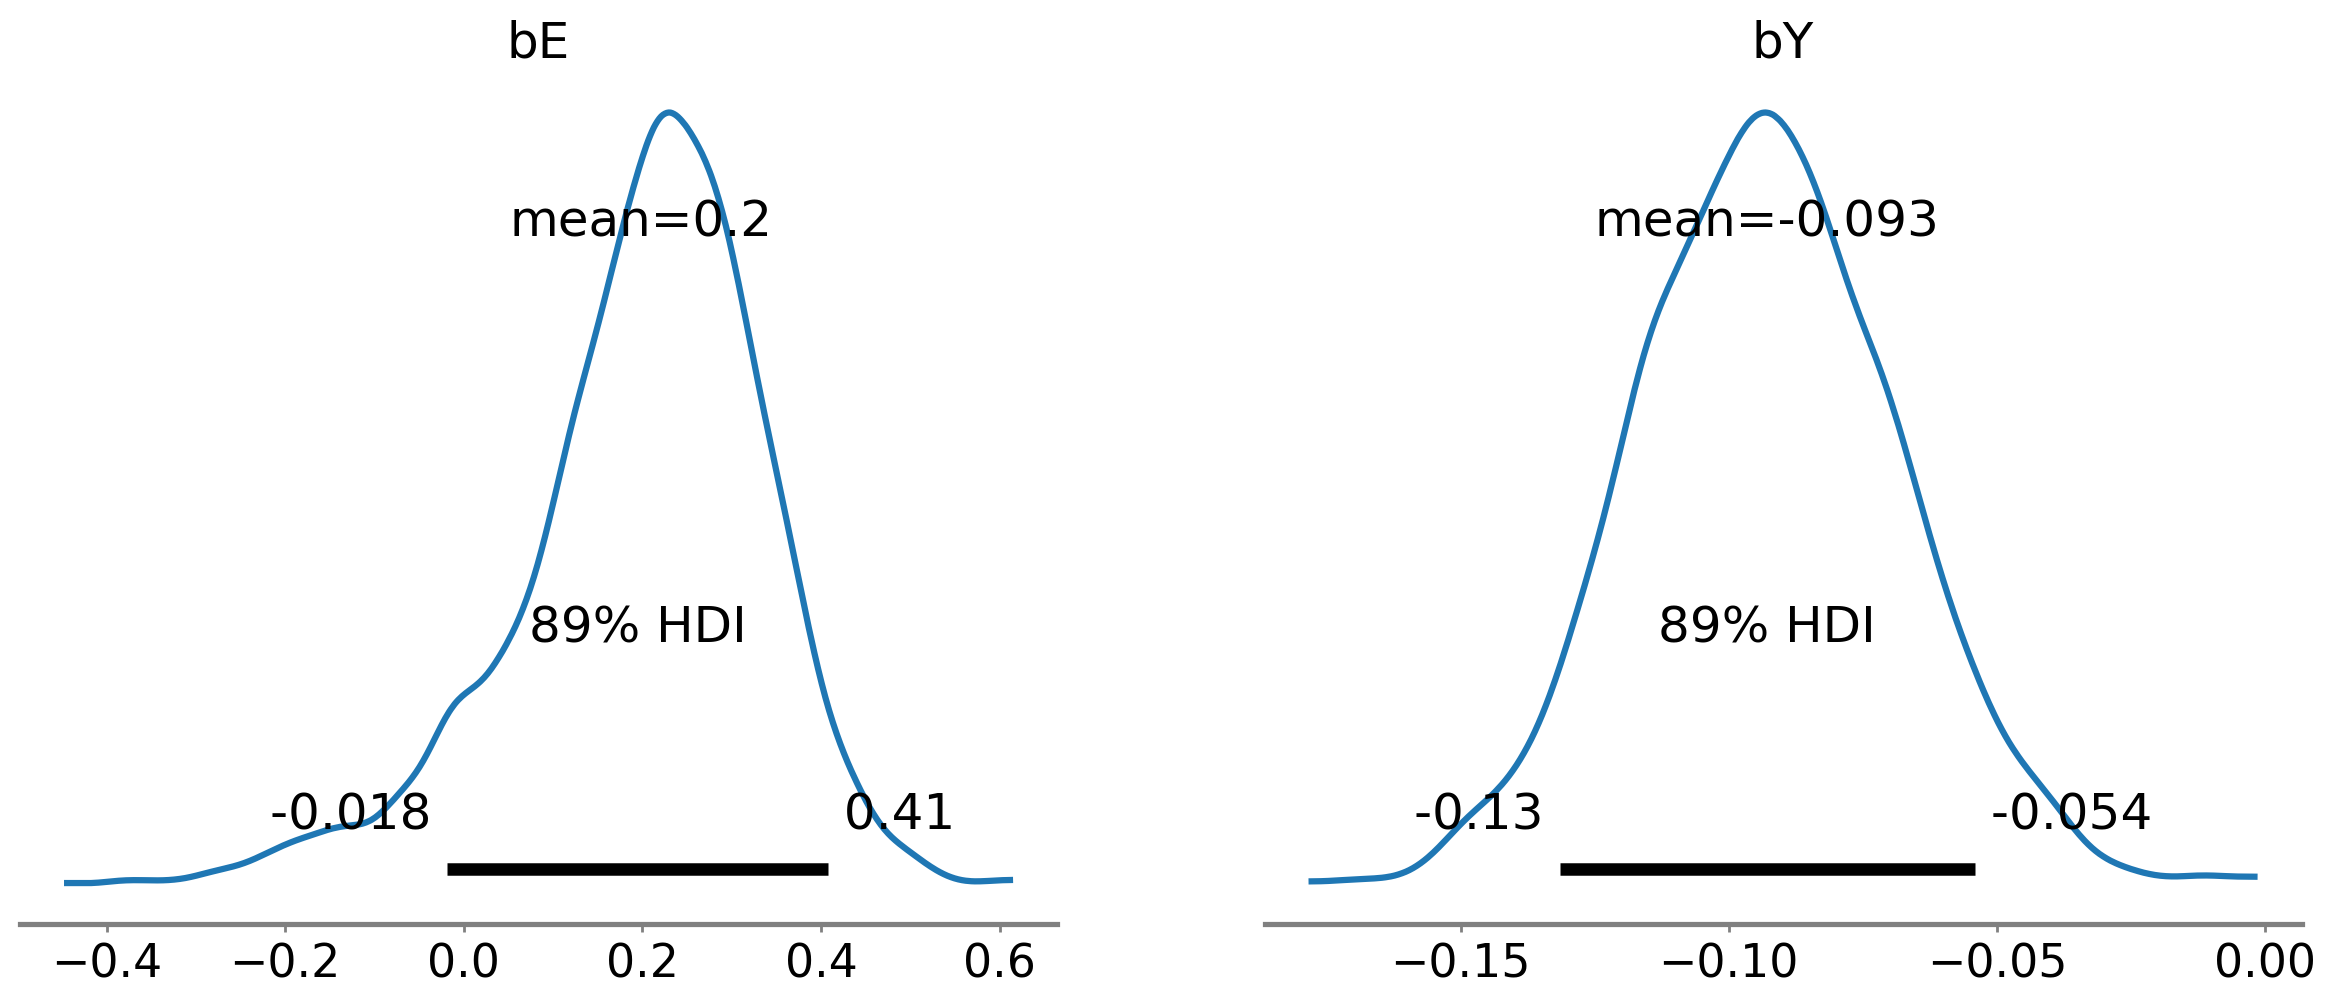

In [33]:
az.plot_forest(idata_RXEY, var_names=["bE", "bY"], combined=True)
az.plot_posterior(idata_RXEY, var_names=["bE", "bY"])

<Axes: title={'center': 'bY_total'}>

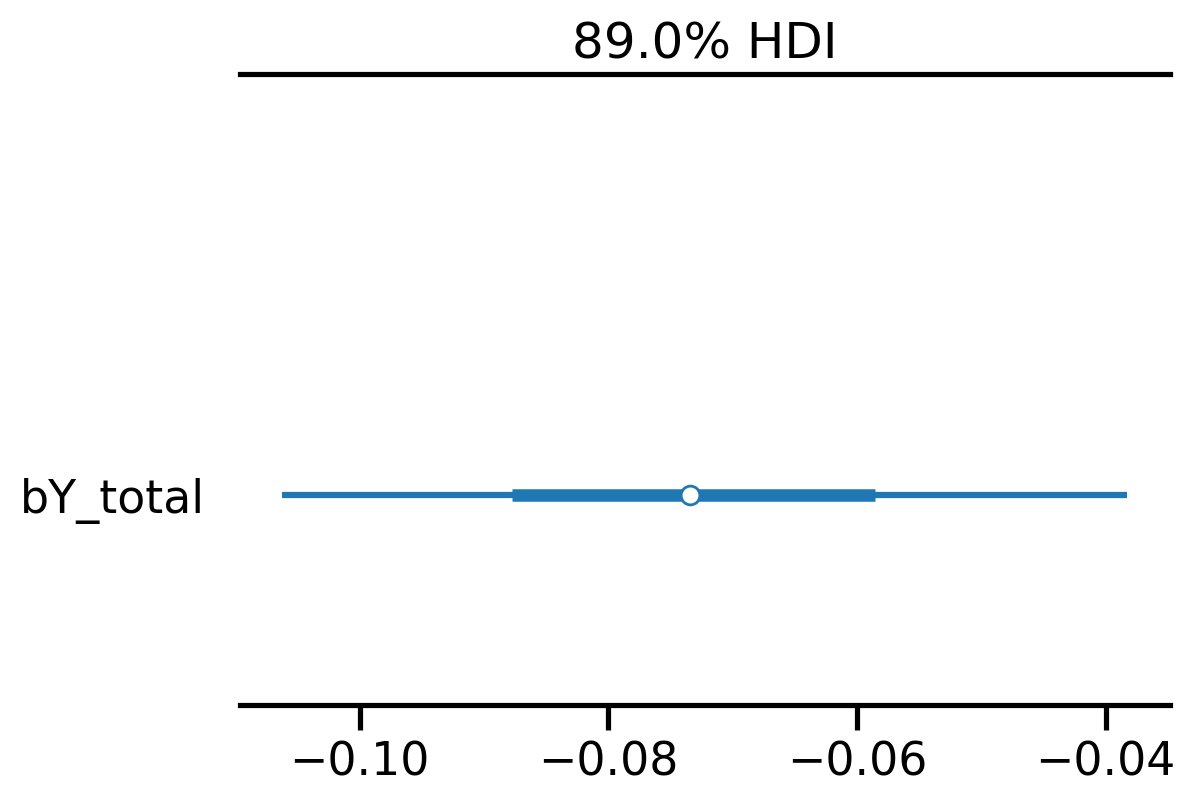

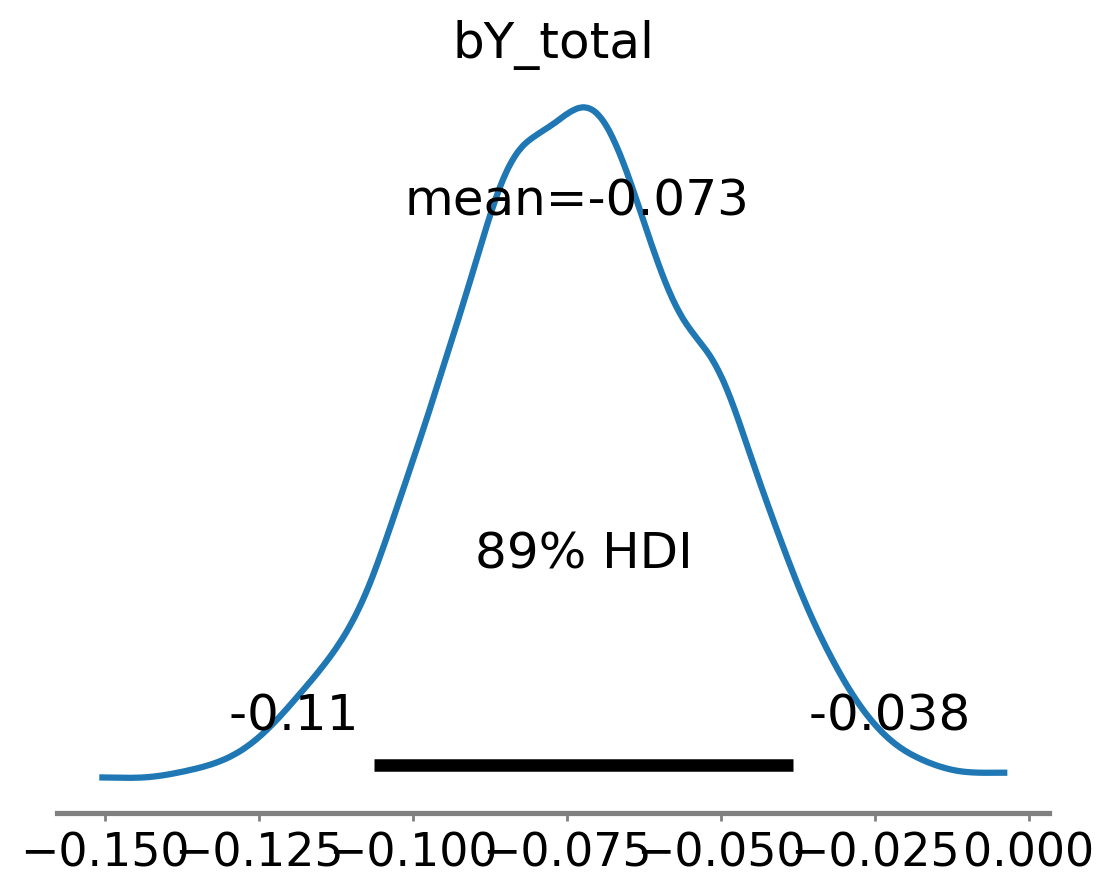

In [34]:
az.plot_forest(idata_RXY, var_names=["bY_total"], combined=True)
az.plot_posterior(idata_RXY, var_names=["bY_total"])

__Answer:__

For total and direct causal influence of education on responses, education is positively correlated with responses, while age is negatively correlated with responses.

For direct causal influence of age on responses, education is positively correlated with responses, while age is negatively correlated with responses.

For total causal influence of age on responses,  age is negatively correlated with responses.

In [35]:
grader.check("q3.3")

q3.3 results: All test cases passed!

<!-- END QUESTION -->



## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [38]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



KeyboardInterrupt: 